In [1]:
import imageio
import warnings
warnings.filterwarnings('ignore')
import cv2
from PIL import Image
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import imageio as io
import pandas as pd
import yaml
import sys
from tqdm.notebook import tqdm_notebook
from matplotlib import patches
from pycocotools import mask as M
from pprint import pprint
import torchmetrics.functional as tf
import torch
sys.path.append('../scripts')
import utils


In [2]:
with open('../config.yaml','r') as f:
    config = yaml.safe_load(f)
    
img_paths = sorted(glob.glob(config['new_dataset']['images']+'/img_thermal_*'))

In [3]:
color_convs = {
    'HLS':cv2.COLOR_RGB2HLS,
    'HSV': cv2.COLOR_RGB2HSV,
    'LAB':cv2.COLOR_RGB2LAB,
    'LUV': cv2.COLOR_RGB2LUV,
    'YUV': cv2.COLOR_RGB2YUV
}

In [4]:
def get_enhanced_image(image_path, apply_ce=False, apply_blur=False, apply_clahe=False, apply_dilation=False):
    c_img = utils.rotate_to_vertical(image_path)
    og_img = c_img
    c_img = cv2.cvtColor(c_img, cv2.COLOR_RGB2GRAY)
    
    if apply_clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(32,32))
        c_img = clahe.apply(c_img)
    
    if apply_ce:
        c_img = cv2.equalizeHist(c_img)
    
    if apply_blur:
        c_img = cv2.GaussianBlur(c_img, (51, 51), 15)

    cvt_img = cv2.cvtColor(og_img, cv2.COLOR_RGB2LAB)
    # cvt_img = og_img
    # img_dilate = None
    
    enhanced_img = cv2.convertScaleAbs(cvt_img[...,0], alpha=2,beta=-70)
    if apply_dilation:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))  # Adjust kernel size as needed
        img_dilate = cv2.dilate(enhanced_img, kernel, iterations=2)
    
    return c_img, og_img, cvt_img, enhanced_img, img_dilate

In [5]:
def gamma_correction(image, gamma):
  image = image / 255.0
  corrected = np.power(image, gamma)
  return np.uint8(corrected * 255.0)

def mixed_pipeline(img_p, apply_erode=False):
    c_img, og_img, cvt_img, enhanced_img, img_dilate = get_enhanced_image(img_p, apply_dilation=True)
    red_green = og_img[...,:2].mean(axis=-1)
    red_green = cv2.GaussianBlur(red_green, (11, 11), 5)
    gamma_rg = gamma_correction(red_green, gamma=2.0)
    gamma_rg_int = (gamma_rg > 20).astype(np.uint8) * 255
    
    # blurred = cv2.GaussianBlur(enhanced_img, (11, 11), 5)
    # blurred = cv2.GaussianBlur(gamma_rg, (11, 11), 5)
    thresh = cv2.adaptiveThreshold(gamma_rg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,21, 5)
    
    if apply_erode:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))  # Adjust kernel size as needed
        thresh = cv2.erode(thresh, kernel, iterations=2)

    _, labels, bboxes, _ = cv2.connectedComponentsWithStats(gamma_rg_int, connectivity=8)

    for box in bboxes[1:]:
        x,y,w,h,area = box
        if area > 5000:
            thresh[y + h:og_img.shape[0],x-30:x+w+30] = 0

    return (bboxes, thresh, og_img)

In [6]:
mask_paths = glob.glob('../../../dataset/Seek Thermal/masks/*.png')
new_img_paths = ['D:/semester 1 study/Goettingen study material/Practical Course Data Fusion/dataset/Seek Thermal/jpegs/'+x.split('\\')[-1].replace('png','jpg') for x in mask_paths]

In [7]:
roi_extracted_imgs = []

n = new_img_paths.__len__()
grid_shape = (int(np.sqrt(n))+1, int(np.sqrt(n))+1)

for i, img_p in tqdm_notebook(enumerate(new_img_paths)):
    bboxes, thresh, og_img = mixed_pipeline(img_p=img_p)
    roi_extracted_img = np.zeros_like(og_img)
    for box in bboxes[1:]:
        x,y,w,h,area = box
        if area > 10000:
            # ax.add_patch(patches.Rectangle((x-10,0),w+20,h+y,edgecolor='red', facecolor='none'))
            roi_extracted_img[0:h+y, x-15:x+w+30] = og_img[0:h+y, x-15:x+w+30]
    
    roi_extracted_imgs.append([bboxes[1:], roi_extracted_img])

0it [00:00, ?it/s]

In [8]:
masks = [imageio.imread(x) for x in mask_paths]
masks = [(mask == 2).astype(np.uint8) for mask in masks]
masks = np.array(masks)

In [9]:
def normalize(img):
    return (img - np.mean(img, axis=(0,1))) / np.std(img, axis=(0,1))

def min_max_scale(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img))

  0%|          | 0/69 [00:00<?, ?it/s]

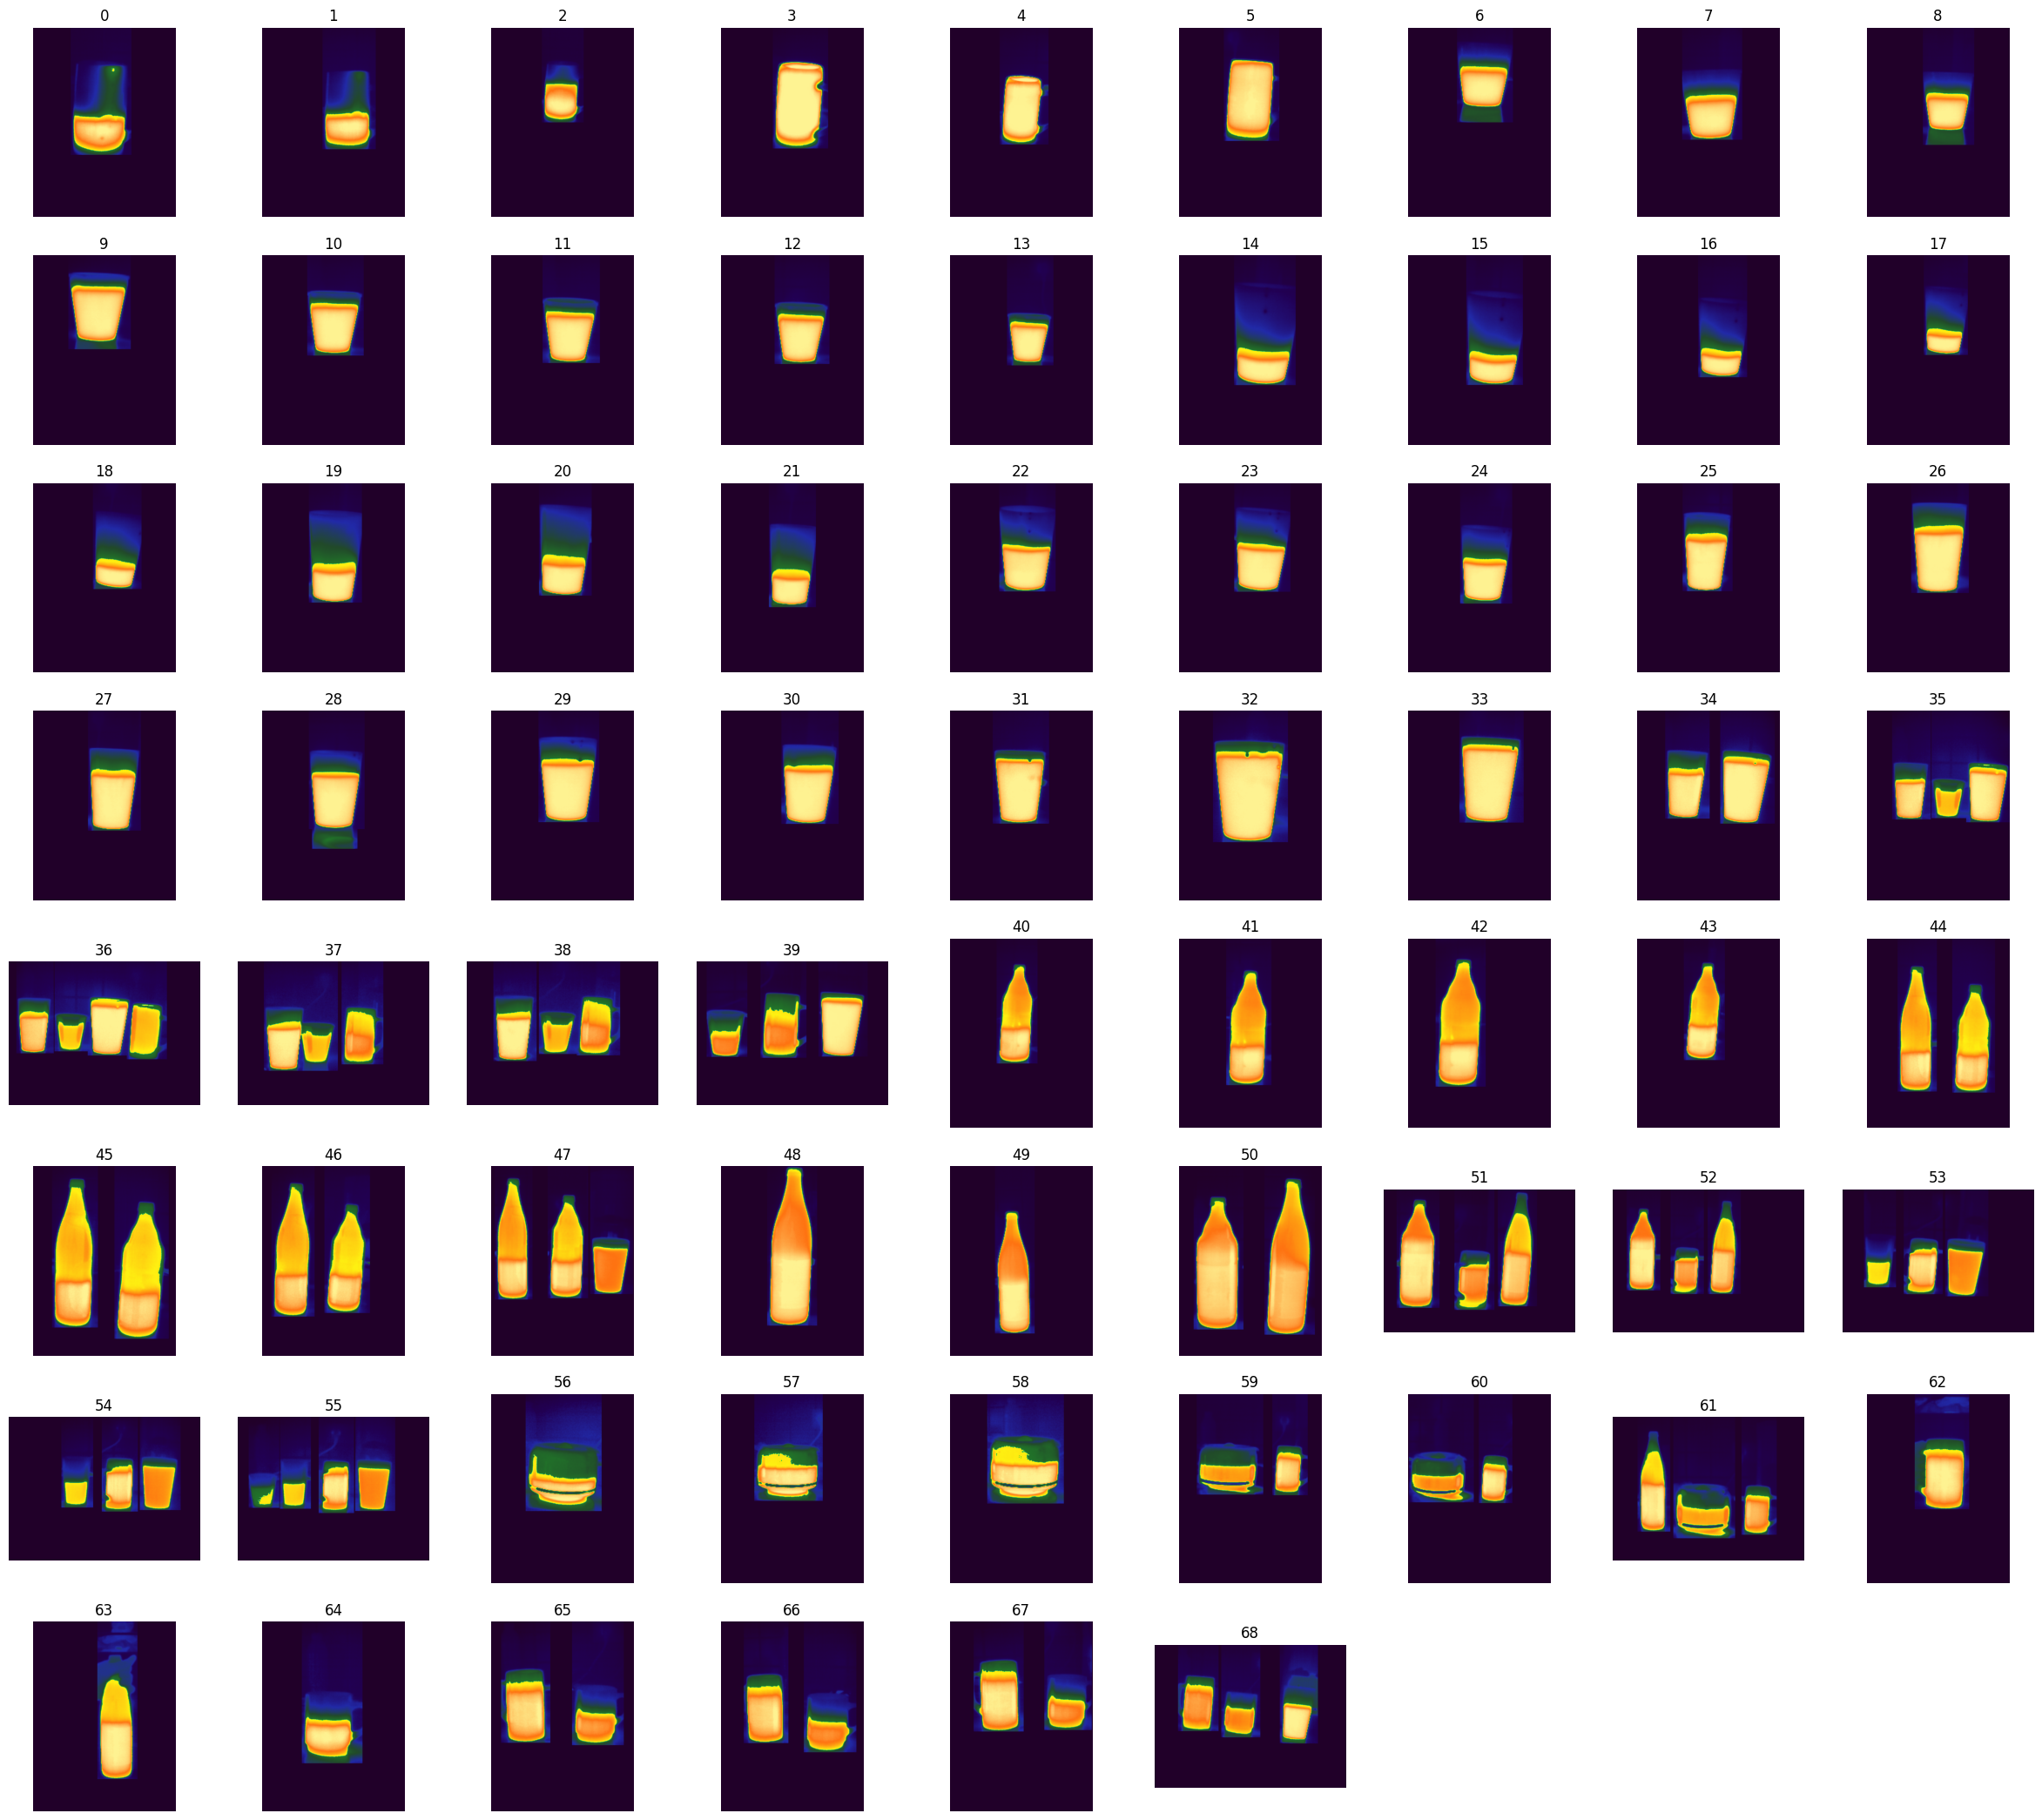

In [11]:
n = mask_paths.__len__()  # total number of images
grid_shape = (int(np.sqrt(n))+1, int(np.sqrt(n))+1)
fig, axs = plt.subplots(nrows=grid_shape[0], ncols=grid_shape[1], figsize=(30, 30))
axs = axs.flatten()
predictions = []

for i in tqdm_notebook(range(roi_extracted_imgs.__len__())):
    ax = axs[i]
    sample_img = roi_extracted_imgs[i][1].copy()
    sample_img[...,0] = (sample_img[...,0] > 200).astype(np.uint8) * 255
    pred = np.zeros((1280,1280))
    bbox = roi_extracted_imgs[i][0][0]
    
    filtered_green = sample_img[...,1] * sample_img[...,0] > 20
    e_img = np.stack([sample_img[...,0],filtered_green, sample_img[...,-1]], -1)
    gray_img = gamma_correction(cv2.cvtColor(e_img, cv2.COLOR_RGB2GRAY), gamma=2.0)
    scaled_gray_img = min_max_scale(gray_img)
    ax.imshow(sample_img)
    ax.imshow(scaled_gray_img > 0.51, alpha=0.5)
    pred[:scaled_gray_img.shape[0], :scaled_gray_img.shape[1]] = (scaled_gray_img > 0.51).astype(np.uint8)
    predictions.append(pred)
    
    # ax.imshow(gray_img > 70, cmap='gray', alpha=0.5)
    # gray = cv2.cvtColor(roi_extracted_imgs[i], cv2.COLOR_RGB2GRAY)
    # ax.imshow(roi_extracted_imgs[i].mean(axis=-1))
    
    ax.set_title(i)
    ax.axis('off')

predictions = np.stack(predictions, axis=0)

for ax in axs[n:]:
    ax.remove()

plt.show()

In [12]:
tf.jaccard_index(preds=torch.Tensor(predictions), target=torch.Tensor(masks),task='binary',average='micro') 

tensor(0.7467)

In [111]:
idx = 15
sample_img = roi_extracted_imgs[idx].copy()


In [ ]:
plt.imshow(sample_img)

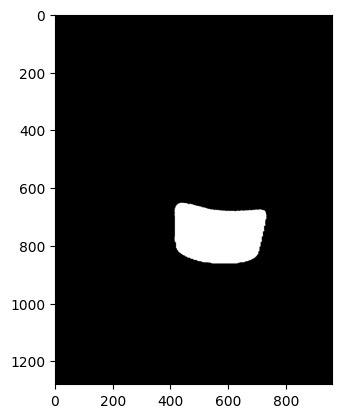

In [113]:
filtered_green = sample_img[...,1] * sample_img[...,0] > 20
e_img = np.stack([sample_img[...,0],filtered_green, sample_img[...,-1]], -1)
gray_img = cv2.cvtColor(e_img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray_img > 70, cmap='gray')

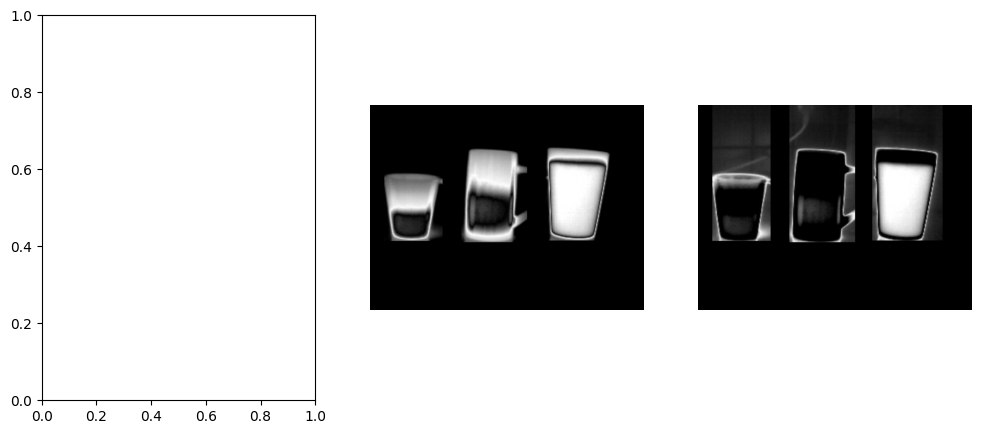

In [69]:
fig, axs = plt.subplots(1,3, figsize=(12,5))

for i in range(1,3):
    axs[i].imshow(sample_img[...,i],cmap='gray')
    axs[i].axis('off')

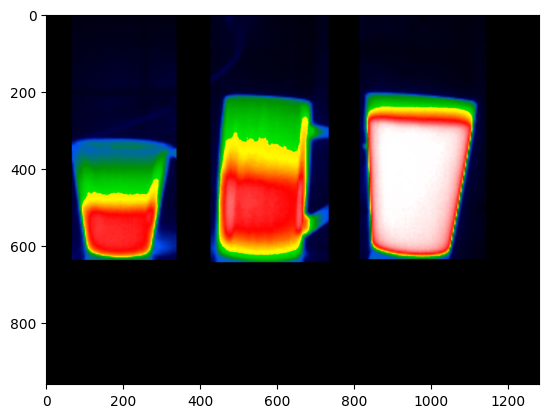

In [89]:
sample_img[...,0] = (sample_img[...,0] > 200).astype(np.uint8) * 255

plt.imshow(sample_img)

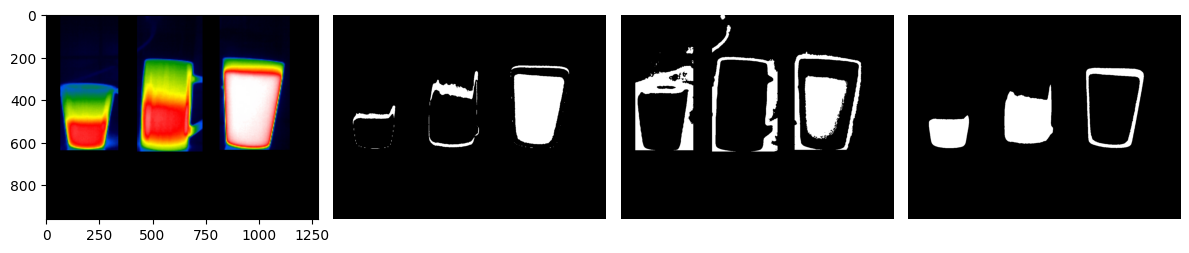

In [53]:
idx = -30

def normalize(img):
    return (img - np.mean(img, axis=(0,1))) / np.std(img, axis=(0,1))

def min_max_scale(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img))

norm_img = (min_max_scale(normalize(roi_extracted_imgs[idx])) * 255).astype(np.uint8)

cvt_img = cv2.cvtColor(norm_img, cv2.COLOR_RGB2YUV)
fig, axs = plt.subplots(1,4, figsize=(12,5))
axs[0].imshow(roi_extracted_imgs[idx])
for i in range(1,4):
    axs[i].imshow(cvt_img[...,i-1] > 150,cmap='gray')
    axs[i].axis('off')
    
plt.tight_layout()

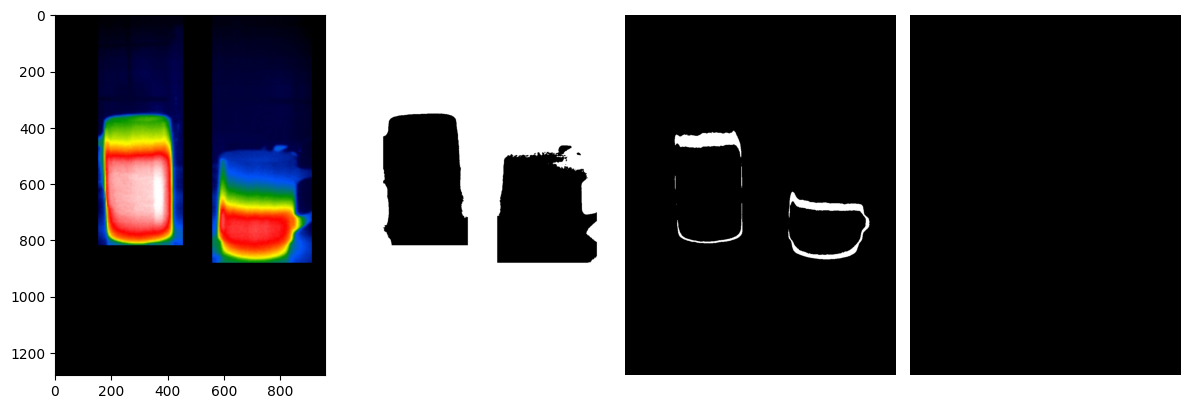

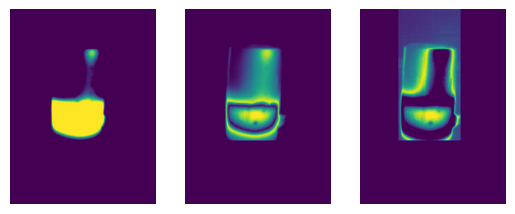

In [13]:
# plt.imshow(norm_img)
fig, axs = plt.subplots(1,3)
for i in range(3):
    axs[i].imshow(norm_img[...,i])
    axs[i].axis('off')

In [ ]:
new_masks = []

for i in range(masks.__len__()):
    yuv_img = cv2.cvtColor(roi_extracted_imgs[i], cv2.COLOR_RGB2YUV)
    v_channel = (yuv_img[...,-1] >= 200).astype(np.uint8)

    mask = np.zeros_like(v_channel, np.uint8)
    contours, _ = cv2.findContours(v_channel, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    mask = cv2.drawContours(mask, [cnt], -1, (255, 255, 255), -1)

    new_mask = np.zeros_like(masks[i])
    new_mask[:mask.shape[0], :mask.shape[1]] = mask
    
    new_masks.append(new_mask)
    
new_masks = np.array(new_masks)

In [ ]:
plt.imshow(new_masks[2])
plt.show()
plt.imshow(masks[2])

In [ ]:
def calculate_iou(pred, target):
  if pred.shape != target.shape:
    raise ValueError("Prediction and target arrays must have the same shape.")

  intersection = np.sum(pred & target)
  union = np.sum(pred | target)
  iou = intersection / (union + np.finfo(float).eps)  # Add epsilon for numerical stability

  return iou

In [ ]:
# new_masks.dtype, masks.dtype
from torchmetrics.functional import jaccard_index
import torch

In [ ]:
new_masks = new_masks // 255

In [ ]:
calculate_iou(new_masks, masks)

In [ ]:
jaccard_index(torch.Tensor(masks), torch.Tensor(new_masks), task='binary', average='micro')

In [ ]:
red_green = roi_extracted_imgs[idx][...,:2].mean(axis=-1)
red_green = cv2.GaussianBlur(red_green, (11, 11), 5)
gamma_rg = gamma_correction(red_green, gamma=2.0)

plt.imshow(gamma_rg > 20)

In [ ]:
idx = 20

fig, axs = plt.subplots(1,4, figsize=(12,4))
for a in axs:
    a.axis('off')

axs[0].imshow(roi_extracted_imgs[idx][...,0])
axs[1].imshow(yuv_img[...,-1], cmap='gray', alpha=0.5)
axs[2].imshow(masks[idx][:yuv_img.shape[0], :yuv_img.shape[1]], cmap='gray')
axs[2].imshow(new_mask, alpha=0.5)
plt.show()

In [ ]:
np.unique(masks), np.unique(new_masks)

In [ ]:
n = mask_paths.__len__()  # total number of images
grid_shape = (int(np.sqrt(n))+1, int(np.sqrt(n))+1)
fig, axs = plt.subplots(nrows=grid_shape[0], ncols=grid_shape[1], figsize=(30, 30))

axs = axs.flatten()

for i in tqdm_notebook(range(mask_paths.__len__())):
    # og_img = utils.rotate_to_vertical(img_p)
    
    ax = axs[i]
    # red_green = roi_extracted_imgs[i][...,:2].mean(axis=-1)
    # red_green = cv2.GaussianBlur(red_green, (11, 11), 5)
    # gamma_rg = gamma_correction(red_green, gamma=2.0)
    gray = cv2.cvtColor(roi_extracted_imgs[i], cv2.COLOR_RGB2GRAY)
    ax.imshow(roi_extracted_imgs[i].mean(axis=-1))
    # ax.imshow((gamma_rg > 20).astype(np.uint8), alpha=0.5)
    
    # ax.imshow(cv2.cvtColor(roi_extracted_imgs[i], cv2.COLOR_RGB2YUV)[...,-1] > 200, cmap='gray')
    
    # X = roi_extracted_imgs[i][...,[0,2]].mean(axis=-1).astype(np.uint8)
    # ax.imshow(roi_extracted_imgs[i][...,0] + roi_extracted_imgs[i][...,2], cmap='gray')
    # ax.imshow(roi_extracted_imgs[i][...,0] * roi_extracted_imgs[i][...,1], cmap='gray')
    # ax.imshow(new_masks[i],alpha=0.5)
    # ax.imshow(masks[i])
    # red = og_img[...,0]
    # red = cv2.GaussianBlur(red, (11, 11), 5)
    # red = (red > 4).astype(np.uint8)
    
    # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 3))  # Adjust kernel size as needed
    # eroded = cv2.erode(red, kernel, iterations=5)
    
    
    ax.set_title(i)
    ax.axis('off')

for ax in axs[n:]:
    ax.remove()

plt.show()